# Homework Assignment 3

## Question 1

### a) Examine the level of clustering in these data using Moran's statistic

In [91]:
# load in the source data
options(jupyter.plot_mimetypes = 'image/png')
set.seed(123)
source("./R-starter-code.R")


# get neigbor standardized weights 
col.W <- nb2listw(nb, style = "W", zero.policy = TRUE)
col.B <- nb2listw(nb, style = "B", zero.policy = TRUE)

In [58]:
# get the residuals from quasi-piosson regression
lm <- glm(Observed ~ 1, offset = log(Expected), data = penn.dat, family = quasipoisson())
lm2 <- glm(Observed ~ x + y , offset = log(Expected), data = penn.dat, family = quasipoisson())

res <- residuals(lm, type = "pearson")
res_adjusted <- residuals(lm2, type = "pearson")

In [59]:
moran.test(res, col.W)
moran.test(res, col.B)
moran.test(res_adjusted, col.W)
moran.test(res_adjusted, col.B)


	Moran I test under randomisation

data:  res  
weights: col.W  

Moran I statistic standard deviate = 3.1996, p-value = 0.0006881
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.223064039      -0.015151515       0.005543012 



	Moran I test under randomisation

data:  res  
weights: col.B  

Moran I statistic standard deviate = 3.2697, p-value = 0.0005383
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.218541561      -0.015151515       0.005108335 



	Moran I test under randomisation

data:  res_adjusted  
weights: col.W  

Moran I statistic standard deviate = 2.4392, p-value = 0.00736
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.166950510      -0.015151515       0.005573616 



	Moran I test under randomisation

data:  res_adjusted  
weights: col.B  

Moran I statistic standard deviate = 2.3227, p-value = 0.0101
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.151310186      -0.015151515       0.005136172 


### b) Examine the level of clustering in these data using Geary's statistic

In [60]:
geary.test(res, col.W)
geary.test(res, col.B)
geary.test(res_adjusted, col.W)
geary.test(res_adjusted, col.B)


	Geary C test under randomisation

data:  res 
weights: col.W 

Geary C statistic standard deviate = 2.834, p-value = 0.002298
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.767209265       1.000000000       0.006747194 



	Geary C test under randomisation

data:  res 
weights: col.B 

Geary C statistic standard deviate = 2.1984, p-value = 0.01396
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
       0.77784441        1.00000000        0.01021162 



	Geary C test under randomisation

data:  res_adjusted 
weights: col.W 

Geary C statistic standard deviate = 2.3376, p-value = 0.009703
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.809401467       1.000000000       0.006647892 



	Geary C test under randomisation

data:  res_adjusted 
weights: col.B 

Geary C statistic standard deviate = 1.9552, p-value = 0.02528
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.807005777       1.000000000       0.009743282 


The general trend for both the Geary and the Moran test was that there 
was an increase in the p-vlaue when moving from "W" style weights to the
"B" style weights and when using a static mean function and one that is
adjusted for latitude and longitude. The Moran test was more affected by 
the latter.

### c) Fit a Poisson lognormal-spatial smoothing model and observe clustering  
The model should fit  

$Y_i | \theta_i \sim Poisson(E_i \theta_i)$  

where  

$log(\theta_i) = \beta \times X + \epsilon_i + S_i$  

with $\epsilon_i$ and $S_i$ non-spatial and ICAR spatial random effects, using inla with the 
default prior settings. Examine the level of clustering by looking at the random effects $S_i$ and 
in particular their size in comparison with the $\epsilon_i$  

In [5]:
penn.dat$ID <- 1:nrow(penn.dat)
penn.dat$ID2 <- 1:nrow(penn.dat)
m1 <- inla(Observed ~ 1 + f(ID, model = "iid") + f(ID2, model = "besag", graph = "./penn.graph"),
           family = "poisson", E = Expected, data = penn.dat, control.predictor = list(compute = TRUE))

In [6]:
penn.dat$nonspatial_random <- exp(m1$summary.random$ID[,5])
penn.dat$spatial_random <- exp(m1$summary.random$ID2[,5])
penn2$nonspatial_random <- penn.dat$nonspatial_random
penn2$spatial_random <- penn.dat$spatial_random

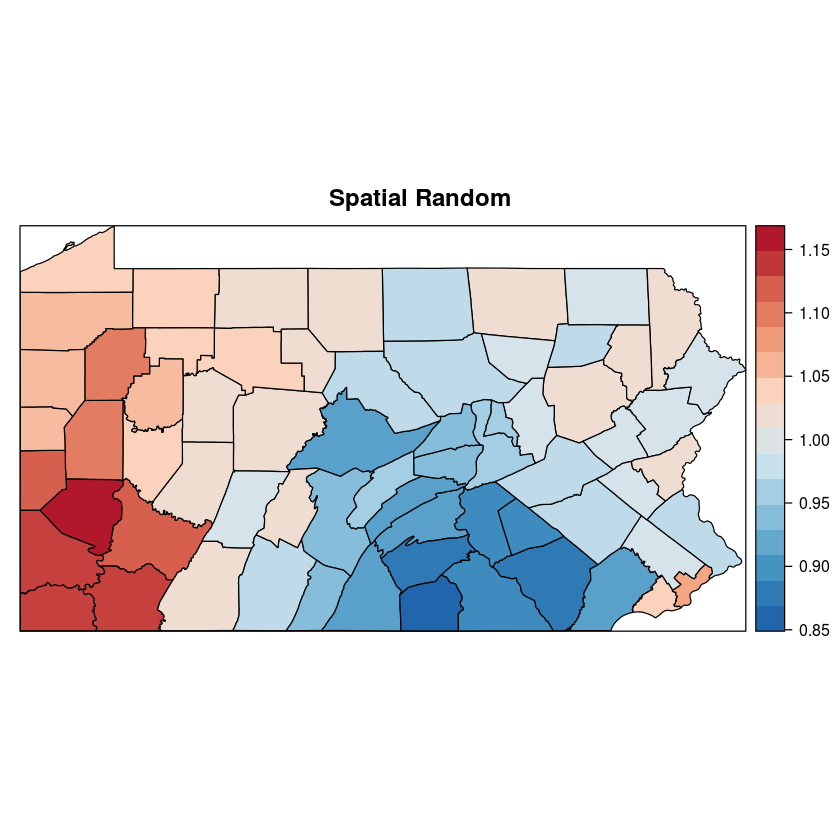

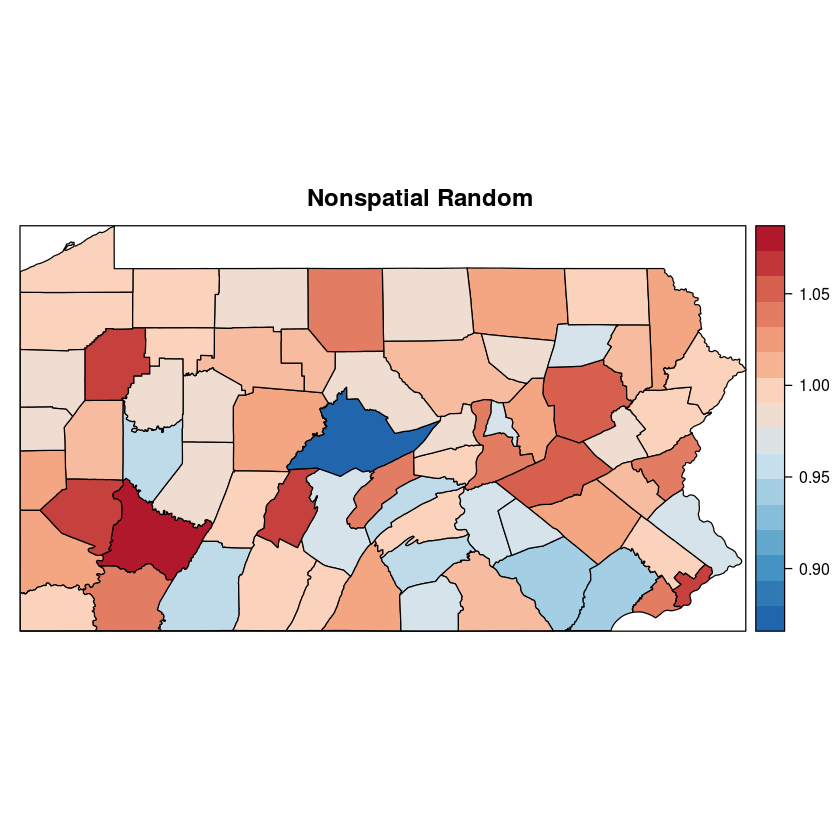

In [7]:
par(mfrow=c(2,1))
spplot(penn2, "spatial_random", main="Spatial Random",
       col.regions = colorRampPalette(rev(brewer.pal(8,"RdBu")))(50))
spplot(penn2, "nonspatial_random", main="Nonspatial Random",
       col.regions = colorRampPalette(rev(brewer.pal(8,"RdBu")))(50))

In [90]:
mat.marg <- matrix(NA, nrow = nrow(penn.dat), ncol = 1000)
m <- m1$marginals.random$ID2
for (i in 1:nrow(penn.dat)) {
    Sre <- m[[i]]
    mat.marg[i, ] <- inla.rmarginal(1000, Sre)
}
var.Sre <- apply(mat.marg, 2, var)
var.eps <- inla.rmarginal(1000, inla.tmarginal(function(x) 1/x, m1$marginals.hyperpar$"Precision for ID2"))
perc.var.Sre <- mean(var.Sre/(var.Sre + var.eps))
print(paste0(round(perc.var.Sre*100,2), "% of variation is spatial"))

[1] "32.34% of variation is spatial"


Since we can not simply comapare $\sigma_u$ against $\sigma_v$ we need to examine the 
variation that both produce by looing at the random effects for both and comparing 
the two via simulation. Looking at the maps it appears that there is some reasonable 
spatial correlation and when estimating the amount of variation that is spatial we find 
about 32% of the dispersion accounted for by spatial effects.

## Question 2: Cluster Detection 

### a) Examine the overdispersion from a poisson log-linear model

In [8]:
kappaval <- function(Y, fitted, df) {
    sum((Y - fitted)^2/fitted)/df
}

kappaest <- kappaval(penn.dat$Observed, lm$fitted.values, lm$df.residual)
nMC <- 1000
ncts <- nrow(penn.dat)
yMC <- matrix(rpois(n = nMC * ncts, lambda = penn.dat$Expected), nrow = ncts, ncol = nMC)
kappaMC <- NULL
for (i in 1:nMC) {
    modMC <- glm(yMC[, i] ~ 1, offset = log(penn.dat$Expected),family = "quasipoisson")
    kappaMC[i] <- kappaval(yMC[, i], modMC$fitted, modMC$df.resid)
}

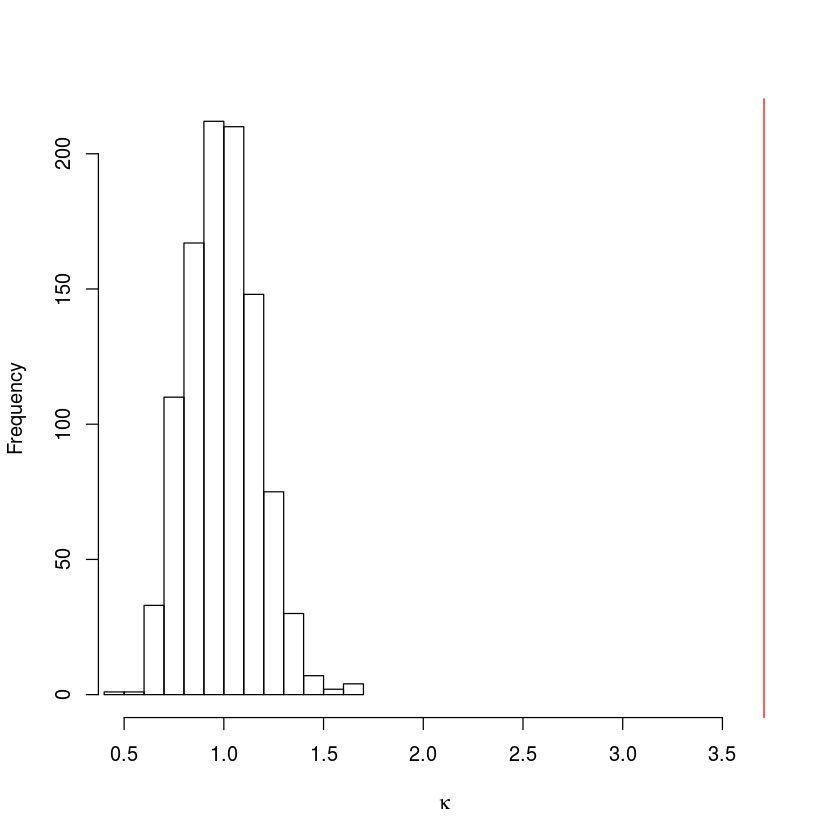

In [9]:
hist(kappaMC, xlim = c(min(kappaMC),max(kappaMC, kappaest)), main = "", xlab = expression(kappa))
abline(v = kappaest, col = "red")

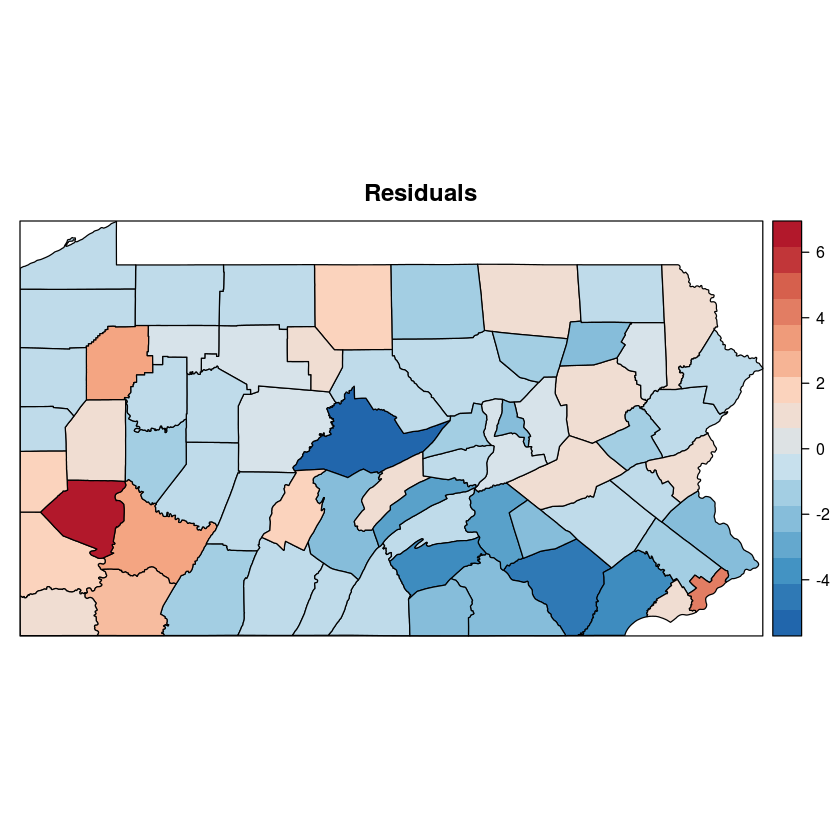

In [54]:
penn2$residuals <- res
par(mfrow=c(1,1))
spplot(penn2, "residuals", main="Residuals",
       col.regions = colorRampPalette(rev(brewer.pal(8,"RdBu")))(50))

It appears that there is more dispersion that would be present in a poisson log-linear 
model. The kappa value is large than would be expected to see at random and a plot of the
residuals shows that spread across the state of PA.

### b) Perform cluster detection on these data using the method of Besag and Newell using $k$ = 500.  

In [28]:
BNresults <- besag_newell(penn.dat[,c("x", "y")], cases=penn.dat$Observed, population=penn.dat$Population, 
                          expected.cases = NULL, k=500, alpha.level=.05)

In [30]:
k <- 500
alpha.level <- 0.01

sig_clusters <- function(alpha, kappa, df=penn.dat){
    BNresults <- besag_newell(df[,c("x", "y")], cases=df$Observed, 
                              population=df$Population, 
                              expected.cases = NULL, k=kappa, alpha.level=alpha)
    length(BNresults$p.values[BNresults$p.values < alpha])
}

In [34]:
alpha_test <- seq(from=.002, to=.2, by=.008)
kappa_test <- seq(from=300, to=6000, by=300)

In [35]:
results <- sapply(alpha_test, function(a) sapply(kappa_test, function(k) sig_clusters(a,k)))
row.names(results) <- kappa_test
colnames(results) <- sprintf("%.3f", alpha_test)
rgb.palette <- colorRampPalette(c("white", "purple"), space = "rgb")

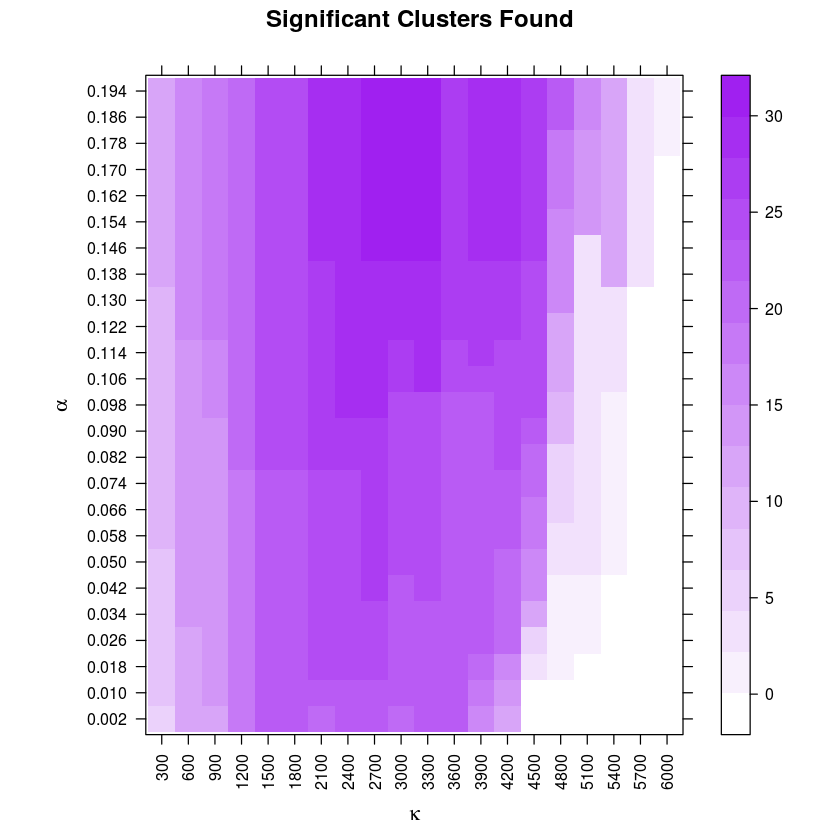

In [36]:
levelplot(results, scales=list(x=list(rot=90)), xlab=expression(kappa), 
          ylab=expression(alpha), main="Significant Clusters Found",
          col.regions=rgb.palette(120))

By varying the levels of $\kappa$ and $\alpha$ we see that we can vary the number 
of significant clusters that we observe. While it may be obvious that when we 
increase $\alpha$ we will see more significant clusters, it is less obvious that 
the number we choose for $\kappa$, the number of cases to consider, has a large 
effect on the number of significant clusters found. Additionally this relationship 
is non-linear.

### c) Perform cluster detection on these data using the SatScan method of Kulldorff. Use a significance level of 0.05, and a maximum population size of 20%

In [15]:
size_cluster <- function(alpha, pop, df=penn.dat){
    KDresults <- kulldorff(df[,c("x", "y")], df$Observed, df$Population, 
                           expected.cases = NULL, pop.upper.bound=pop,
                           n.simulations=999, alpha.level=alpha, plot=F)
    length(KDresults$most.likely.cluster$location.IDs.included)
}

In [37]:
pop_proportions <- seq(from=.02, to=.5, by=.01)

In [39]:
results <- sapply(pop_proportions, function(p) size_cluster(.05,p))

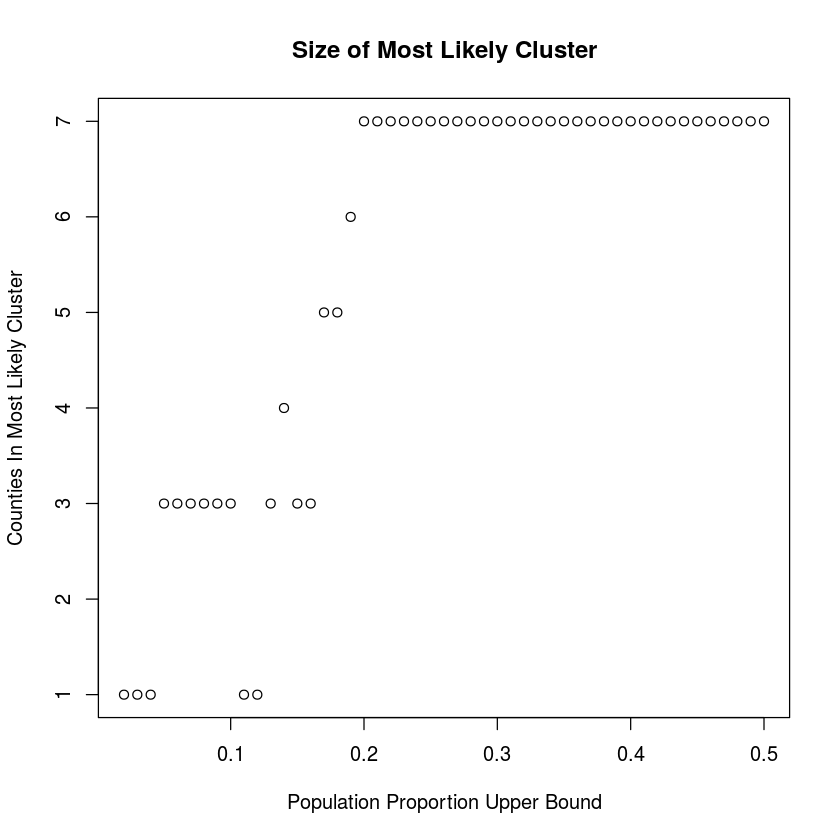

In [43]:
plot(pop_proportions, results, ylab="Counties In Most Likely Cluster",
     xlab="Population Proportion Upper Bound",
     main="Size of Most Likely Cluster")

As we increase the limit for the proportion of the population that can be found 
in a single cluster we see that the number of counties in the most likely cluster 
increases. This should not come as a surprise as raising this limit increases the 
"circle" size and allows for more counties in a single cluster.

### c) Use the Spatial model as a tool for cluster detection. 
Are there are disadvantages of using the model for this purpose?

In [56]:
penn2$RRpmed1 <- m1$summary.fitted.values[, 1]
penn2$RRpmed1_low <-  penn2$RRpmed1  < .85
penn2$RRpmed1_high <-  penn2$RRpmed1  > 1.10

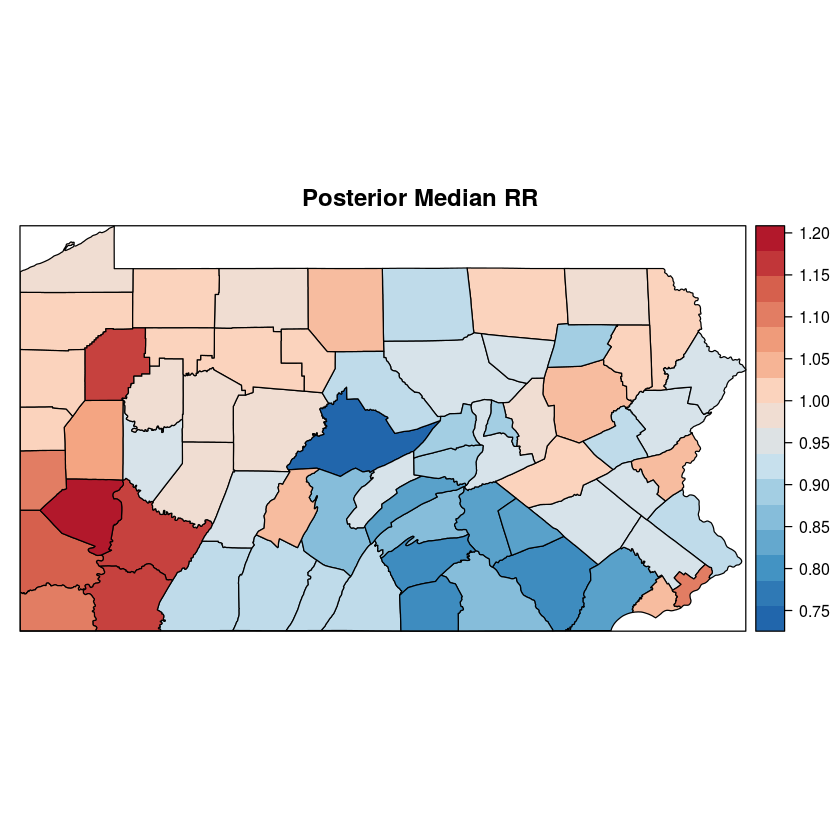

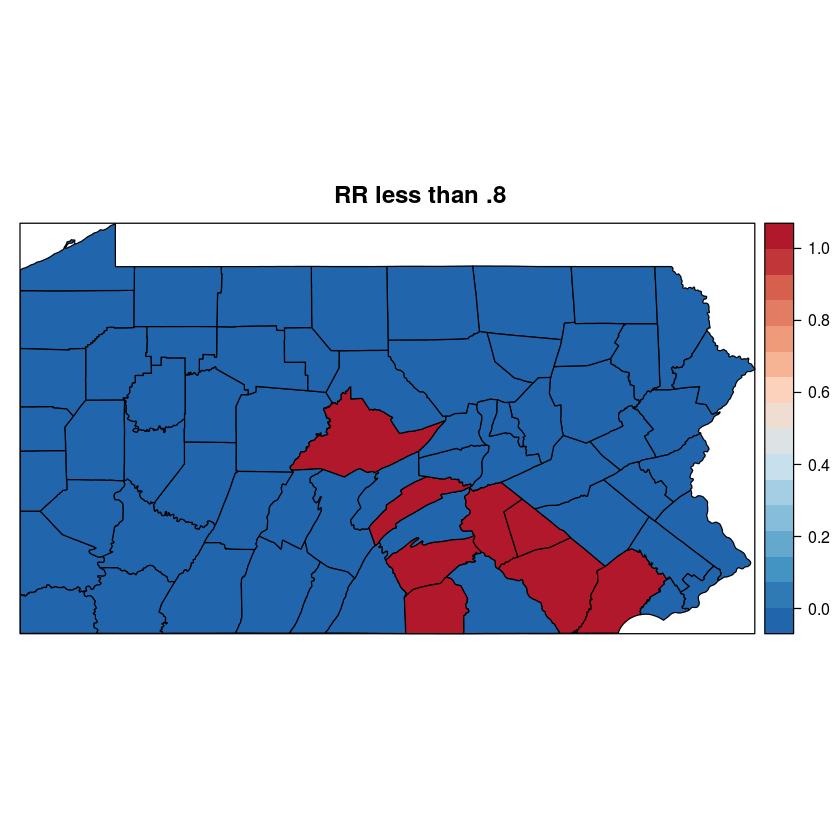

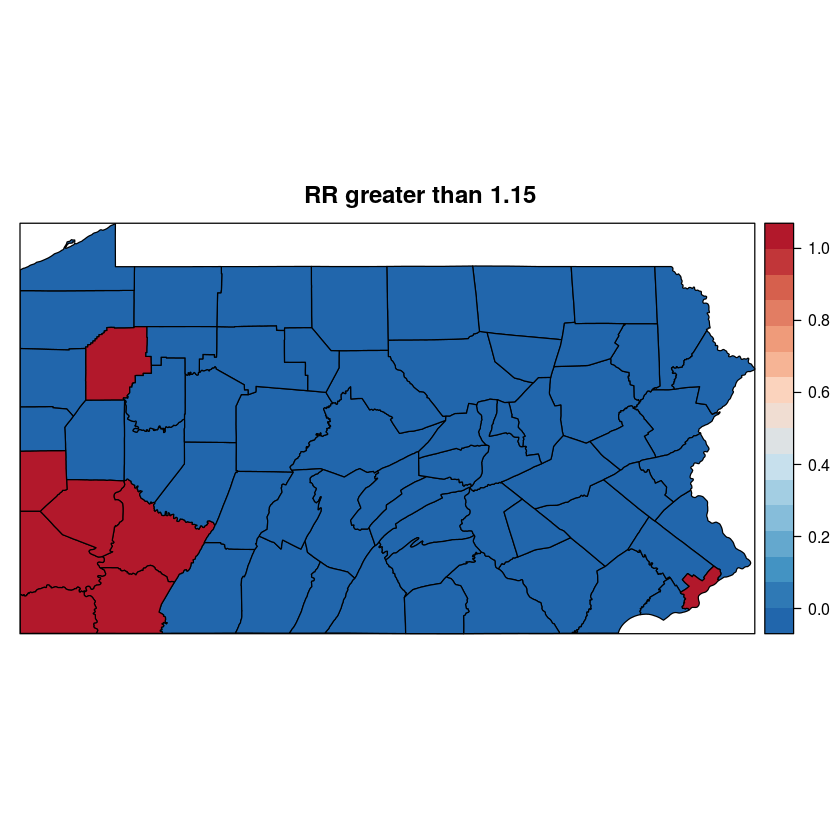

In [57]:
spplot(penn2, "RRpmed1", main="Posterior Median RR",
       col.regions = colorRampPalette(rev(brewer.pal(8,"RdBu")))(50))
spplot(penn2, "RRpmed1_low", main="RR less than .8",
       col.regions = colorRampPalette(rev(brewer.pal(8,"RdBu")))(50))
spplot(penn2, "RRpmed1_high", main="RR greater than 1.15",
       col.regions = colorRampPalette(rev(brewer.pal(8,"RdBu")))(50))

Using the spatial residual model we can easily find pockets of high or low values of 
posterior relative risk. The difficulty with this is that there is no systematic ways 
to find clusters, no test statistic to make a threshold for a cluster being a true 
cluster, and no simple way to divide cutoffs between clusters. Because of this using
a model based approach may not be the best way to do exploratory searching of possible 
clusters in a dataset.